In [5]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

In [6]:
# Load the data by reading the logfile

data = pd.read_csv('data/data/driving_log.csv',dtype={'center': str, 'left':str,'right':str,
                                                      'steering': np.float32,'throttle': np.float32,
                                                      'brake': np.float32,'speed': np.float32},
                   skipinitialspace=1)
                   #converters={'category',"Price":int} dtype='category')
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

center = data['center']
left = data['left']
right = data['right']
steering = data['steering']
throttle = data['throttle']
speed=data['speed']
brake=data['brake']
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Training throttle size = ',len(throttle))
print('Training speed size = ',len(speed))

print('Data loaded')

center       object
left         object
right        object
steering    float32
throttle    float32
brake       float32
speed       float32
dtype: object
Training data size =  8036
Training labels size =  8036
Training throttle size =  8036
Training speed size =  8036
Data loaded


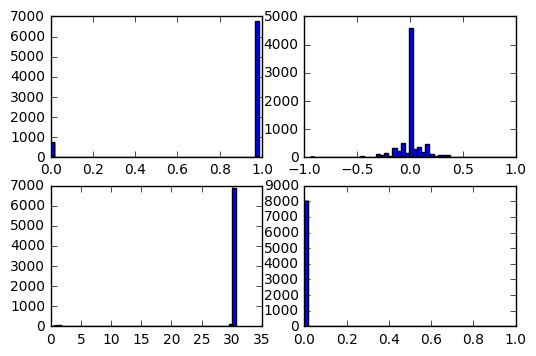

1.0
0.985533


In [7]:
# examine the data
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
plt.hist(throttle,50)
ax = fig.add_subplot(2,2,2)
plt.hist(steering,50)
ax = fig.add_subplot(2,2,3)
plt.hist(speed,50)
ax = fig.add_subplot(2,2,4)
plt.hist(brake,50)
plt.show()
print(max(brake))
print(max(throttle))

In [8]:
def shift_and_crop (filename,steering,direction):
    img = cv2.imread(filename)
    rows,cols,channels = img.shape
    if direction == 'l' or direction == 'left':
        M = np.float32([[1,0,-10],[0,1,0]]) # REMEMBER TO ADD STEERING
        dst = cv2.warpAffine(img,M,(cols,rows))
        crop_img = crop_image(dst)
        steering = steering-0.2
    else:
        M = np.float32([[1,0,10],[0,1,0]]) # REMEMBER TO ADD STEERING
        dst = cv2.warpAffine(img,M,(cols,rows))
        crop_img = crop_image(dst)
        steering = steering+0.2
    
    return crop_img, steering

def crop_image(dst): 
    crop_img = dst[60:140, 10:310] # original size 320 x 160, final size 300 x 80crop_img
    return crop_img

print('crop_images function defined')

crop_images function defined


In [9]:
# augment data by:
# 1) using all images, center, left and righ 
#     a) crop all images to relevant section (remove car and sky) 
# 2) duplicate and flip images (invert steering)
#     a) crop
# 3) shift images to left and right 
# of all above just save those which fall under the desired probability

import random

random.seed()
count = 0

print('Saving augmented images. Please wait...')

for i in range(len(center)):
#for i in range(10):
    # 1) using all images, center, left and righ
    new_images = []
    new_steering = []
#     a) crop all images to relevant section (remove car and sky) 

    filename = 'data/data/'+center[i]
    new_steering.append (steering[i])
    img = cv2.imread(filename)
    crop_img = crop_image(img)
    new_images.append(crop_img)
    
    new_img, new_st = shift_and_crop (filename,steering[i],'left')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    new_img, new_st = shift_and_crop (filename,steering[i],'right')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    filename = 'data/data/'+left[i]
    new_steering.append(steering[i]+0.2)
    img = cv2.imread(filename)
    crop_img = crop_image(img)
    new_images.append(crop_img)
    
    new_img, new_st = shift_and_crop (filename,steering[i]+0.2,'left')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    new_img, new_st = shift_and_crop (filename,steering[i]+0.2,'right')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    filename = 'data/data/'+right[i]
    new_steering.append(steering[i]-0.2)
    img = cv2.imread(filename)
    crop_img = crop_image(img)
    new_images.append(crop_img)
    
    new_img, new_st = shift_and_crop (filename,steering[i]-0.2,'left')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    new_img, new_st = shift_and_crop (filename,steering[i]-0.2,'right')
    new_images.append(new_img)
    new_steering.append(new_st)
    assert (len(new_images)==9)
    
    for j in range(len(new_images)):
        # add flipped images
        new_images.append(cv2.flip(new_images[j],1))
        new_steering.append((new_steering[j])*(-1))

    assert (len(new_images)==18)
    
    # save according to the probability
    # higher steering have higher probability of being saved
    logfile = open('./data/new_data/new_log.csv','a')
    for j in range(len(new_images)):
        rand_num = random.random()
        #print(rand_num,',',abs(new_steering[j]))
        if (abs(new_steering[j])+0.1)>=rand_num:
            #save this image to the final set    
            filename = 'IMG/image_'+str(count)+'.jpg'
            count = count+1
            cv2.imwrite('data/new_data/'+filename,new_images[j])
            logfile.write(filename+','+str(new_steering[j])+'\n')

    logfile.close()

print('Data saved')

Saving augmented images. Please wait...
Data saved


In [10]:
print('Total images saved:',count)

Total images saved: 44307
